# Modification of Santa's 2019 Starter Notebook for Genetic Algorithm method

In [1]:
#PATH_INPUT = '/kaggle/input'
PATH_INPUT = 'kaggle/input'

PATH_TO_SAVE_DATA = "../../data/"
PATH_BASELINE_0 = PATH_TO_SAVE_DATA + '/df_fake_news.pkl'

In [117]:
pwd

'/Users/gregory/Documents/CloudStationSinchon/Applications/python/OC_IML_projet_8/code/santa-workshop-tour-2019'

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import seaborn as sns
sns.set(color_codes=True, font_scale=1.33)

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import time 
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# to save 
import pickle
from sklearn.externals import joblib

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) 
# will list all files under the input directory

import os
for dirname, _, filenames in os.walk(PATH_INPUT):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

kaggle/input/.DS_Store
kaggle/input/santa-2019-workshop-scheduling/family_data.csv
kaggle/input/santa-2019-workshop-scheduling/sample_submission.csv


## Read in the family information and sample submission

In [4]:
fpath = PATH_INPUT + '/santa-2019-workshop-scheduling/family_data.csv'
data = pd.read_csv(fpath, index_col='family_id')

fpath = PATH_INPUT + '/santa-2019-workshop-scheduling/sample_submission.csv'
submission = pd.read_csv(fpath, index_col='family_id')

In [5]:
data.head()

,choice_0,choice_1,choice_2,choice_3,choice_4,choice_5,choice_6,choice_7,choice_8,choice_9,n_people
family_id,,,,,,,,,,,
0,52,38,12,82,33,75,64,76,10,28,4
1,26,4,82,5,11,47,38,6,66,61,4
2,100,54,25,12,27,82,10,89,80,33,3
3,2,95,1,96,32,6,40,31,9,59,2
4,53,1,47,93,26,3,46,16,42,39,4


In [6]:
submission.head()

,assigned_day
family_id,
0,100
1,99
2,98
3,97
4,96


## Create some lookup dictionaries and define constants

You don't need to do it this way. :-)

In [7]:
family_size_dict = data[['n_people']].to_dict()['n_people']

cols = [f'choice_{i}' for i in range(10)]
choice_dict = data[cols].to_dict()

N_DAYS = 100
MAX_OCCUPANCY = 300
MIN_OCCUPANCY = 125

# from 100 to 1
days = list(range(N_DAYS,0,-1))

## Cost Function
Very un-optimized  ;-)

In [8]:
def cost_function(prediction):

    penalty = 0

    # We'll use this to count the number of people scheduled each day
    daily_occupancy = {k:0 for k in days}
    
    # Looping over each family; d is the day for each family f
    for f, d in enumerate(prediction):

        # Using our lookup dictionaries to make simpler variable names
        n = family_size_dict[f]
        choice_0 = choice_dict['choice_0'][f]
        choice_1 = choice_dict['choice_1'][f]
        choice_2 = choice_dict['choice_2'][f]
        choice_3 = choice_dict['choice_3'][f]
        choice_4 = choice_dict['choice_4'][f]
        choice_5 = choice_dict['choice_5'][f]
        choice_6 = choice_dict['choice_6'][f]
        choice_7 = choice_dict['choice_7'][f]
        choice_8 = choice_dict['choice_8'][f]
        choice_9 = choice_dict['choice_9'][f]

        # add the family member count to the daily occupancy
        daily_occupancy[d] += n

        # Calculate the penalty for not getting top preference
        if d == choice_0:
            penalty += 0
        elif d == choice_1:
            penalty += 50
        elif d == choice_2:
            penalty += 50 + 9 * n
        elif d == choice_3:
            penalty += 100 + 9 * n
        elif d == choice_4:
            penalty += 200 + 9 * n
        elif d == choice_5:
            penalty += 200 + 18 * n
        elif d == choice_6:
            penalty += 300 + 18 * n
        elif d == choice_7:
            penalty += 300 + 36 * n
        elif d == choice_8:
            penalty += 400 + 36 * n
        elif d == choice_9:
            penalty += 500 + 36 * n + 199 * n
        else:
            penalty += 500 + 36 * n + 398 * n

    # for each date, check total occupancy
    #  (using soft constraints instead of hard constraints)
    for _, v in daily_occupancy.items():
        if (v > MAX_OCCUPANCY) or (v < MIN_OCCUPANCY):
            penalty += 100000000

    # Calculate the accounting cost
    # The first day (day 100) is treated special
    accounting_cost = (daily_occupancy[days[0]]-125.0) / 400.0 * daily_occupancy[days[0]]**(0.5)
    # using the max function because the soft constraints might allow occupancy to dip below 125
    accounting_cost = max(0, accounting_cost)
    
    # Loop over the rest of the days, keeping track of previous count
    yesterday_count = daily_occupancy[days[0]]
    for day in days[1:]:
        today_count = daily_occupancy[day]
        diff = abs(today_count - yesterday_count)
        accounting_cost += max(0, (daily_occupancy[day]-125.0) / 400.0 * daily_occupancy[day]**(0.5 + diff / 50.0))
        yesterday_count = today_count

    penalty += accounting_cost

    return penalty

## Simple Opimization Approach

For each family, loop over their choices, and if keep it if the score improves. There's a lot of easy improvement that can be made to this code.

In [17]:
t_fit_0 = time.time()
# Start with the sample submission values
best = submission['assigned_day'].tolist()
start_cost = cost_function(best)
print("Start cost: ", start_cost)
new = best.copy()
cost_best = start_cost
# loop over each family
for fam_id, _ in enumerate(best):
    # loop over each family choice
    for pick in range(10):
        day = choice_dict[f'choice_{pick}'][fam_id]
        temp = new.copy()
        temp[fam_id] = day # add in the new pick
        cost_curr = cost_function(temp) # test cost
        if cost_curr < cost_best:
            new = temp.copy()
            cost_best = cost_curr
            #print("Current best cost: ", cost_best)

submission['assigned_day'] = new
score = cost_function(new)
submission.to_csv(f'submission_{score}.csv')
print(f'Score: {score}')

t_fit_1 = time.time()
print("Timing: ", t_fit_1 - t_fit_0)



Start cost:  10641498.403135022
Score: 672254.0276683343
Timing:  380.70853185653687


In [ ]:
# save for later use
joblib.dump(submission, PATH_BASELINE_0)

## Explore family choice cost

In [25]:
def cost_family(n=1, choice=0):
    # Calculate the penalty for not getting top preference
    penalty = 0
    if choice == 0:
        penalty += 0
    elif choice == 1:
        penalty += 50
    elif choice == 2:
        penalty += 50 + 9 * n
    elif choice == 3:
        penalty += 100 + 9 * n
    elif choice == 4:
        penalty += 200 + 9 * n
    elif choice == 5:
        penalty += 200 + 18 * n
    elif choice == 6:
        penalty += 300 + 18 * n
    elif choice == 7:
        penalty += 300 + 36 * n
    elif choice == 8:
        penalty += 400 + 36 * n
    elif choice == 9:
        penalty += 500 + 36 * n + 199 * n
    else:
        penalty += 500 + 36 * n + 398 * n
        
    return penalty

In [29]:
cost_family(choice=1, n=2)

50

### Evolution of cost by number of people into family

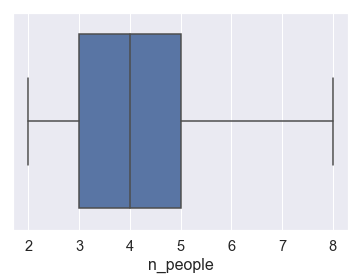

In [11]:
ax = sns.boxplot(x=data["n_people"])


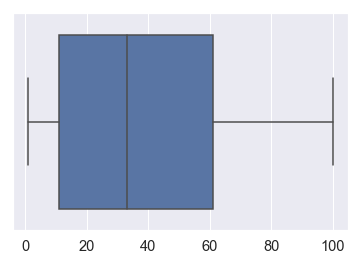

In [176]:
ax = sns.boxplot(data)

In [24]:
df_fam_cost = pd.DataFrame(index = np.array(range(np.min(data["n_people"]),
                            np.max(data["n_people"]) + 1)),
            columns=['choice_{}'.format(n_choice) for n_choice in range(0, 11)])
df_fam_cost["n"] = df_fam_cost.index
df_fam_cost

,choice_0,choice_1,choice_2,choice_3,choice_4,choice_5,choice_6,choice_7,choice_8,choice_9,choice_10,n
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8


In [32]:
df_fam_cost["choice_0"] = df_fam_cost["n"].apply(cost_family, args=(0,))
df_fam_cost["choice_1"] = df_fam_cost["n"].apply(cost_family, args=(1,))
df_fam_cost["choice_2"] = df_fam_cost["n"].apply(cost_family, args=(2,))
df_fam_cost["choice_3"] = df_fam_cost["n"].apply(cost_family, args=(3,))
df_fam_cost["choice_4"] = df_fam_cost["n"].apply(cost_family, args=(4,))
df_fam_cost["choice_5"] = df_fam_cost["n"].apply(cost_family, args=(5,))
df_fam_cost["choice_6"] = df_fam_cost["n"].apply(cost_family, args=(6,))
df_fam_cost["choice_7"] = df_fam_cost["n"].apply(cost_family, args=(7,))
df_fam_cost["choice_8"] = df_fam_cost["n"].apply(cost_family, args=(8,))
df_fam_cost["choice_9"] = df_fam_cost["n"].apply(cost_family, args=(9,))
df_fam_cost["choice_10"] = df_fam_cost["n"].apply(cost_family, args=(10,))
df_fam_cost

,choice_0,choice_1,choice_2,choice_3,choice_4,choice_5,choice_6,choice_7,choice_8,choice_9,choice_10,n
2,0,50,68,118,218,236,336,372,472,970,1368,2
3,0,50,77,127,227,254,354,408,508,1205,1802,3
4,0,50,86,136,236,272,372,444,544,1440,2236,4
5,0,50,95,145,245,290,390,480,580,1675,2670,5
6,0,50,104,154,254,308,408,516,616,1910,3104,6
7,0,50,113,163,263,326,426,552,652,2145,3538,7
8,0,50,122,172,272,344,444,588,688,2380,3972,8


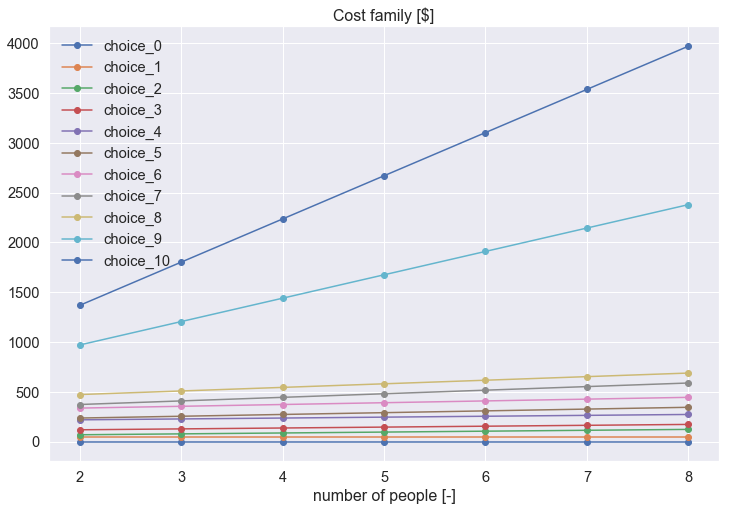

In [43]:
fig = plt.figure(figsize=(12, 8))
plt.title("Cost family [$]")
list_choice = ['choice_{}'.format(n_choice) for n_choice in range(0, 11)]

for choice in list_choice:
    plt.plot(df_fam_cost["n"], df_fam_cost[choice], '-o', label=choice)
plt.legend(loc='upper left');

ax = fig.gca()
ax.set_xlabel("number of people [-]");

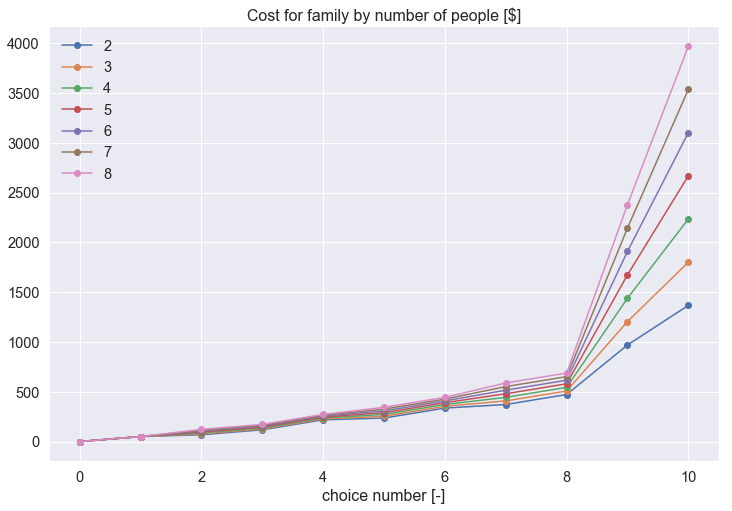

In [70]:
fig = plt.figure(figsize=(12, 8))
plt.title("Cost for family by number of people [$]")
list_choice = ['choice_{}'.format(n_choice) for n_choice in range(0, 11)]

for n in df_fam_cost["n"]:
    plt.plot(range(0, df_fam_cost.filter(items=list_choice).shape[1]), 
        np.array(df_fam_cost.filter(items=list_choice).filter(items=[n], 
                                                              axis=0))[0],
             '-o', label=n)
plt.legend(loc='upper left');

ax = fig.gca()
ax.set_xlabel("choice number [-]");

### Creation of probability matrix

In [122]:
# For genetic algo, for start population or mutation,
# try to assign probabilities of choice for each possibilities : 
# from  choice 0 to 10.
df_prob = df_fam_cost.filter(items=list_choice)
vect_penalty = [0, np.max(np.max(df_prob))]
print("vect_penalty: ", vect_penalty)
vect_prob = [0.1, 0.03]
print("vect_prob", vect_prob)
# family : number of people
df_prob = df_prob.applymap(lambda x: np.interp(x, vect_penalty, vect_prob))
for indice in df_prob.index:
    df_prob.loc[indice] = df_prob.loc[indice]/df_prob.loc[indice].sum()

df_prob

vect_penalty:  [0, 3972]
vect_prob [0.1, 0.03]


,choice_0,choice_1,choice_2,choice_3,choice_4,choice_5,choice_6,choice_7,choice_8,choice_9,choice_10
2,0.097481,0.096622,0.096313,0.095454,0.093736,0.093427,0.091709,0.091090,0.089372,0.080817,0.073980
3,0.098846,0.097975,0.097505,0.096634,0.094892,0.094422,0.092680,0.091739,0.089997,0.077855,0.067455
4,0.100250,0.099367,0.098731,0.097848,0.096081,0.095445,0.093678,0.092406,0.090639,0.074809,0.060746
5,0.101695,0.100799,0.099992,0.099096,0.097304,0.096498,0.094705,0.093092,0.091300,0.071675,0.053843
6,0.103182,0.102272,0.101291,0.100381,0.098563,0.097581,0.095763,0.093799,0.091980,0.068450,0.046738
7,0.104713,0.103790,0.102627,0.101705,0.099859,0.098697,0.096851,0.094526,0.092681,0.065129,0.039423
8,0.106290,0.105353,0.104004,0.103068,0.101195,0.099846,0.097973,0.095275,0.093402,0.061708,0.031887


In [116]:
df_prob = df_fam_cost.filter(items=list_choice)

,choice_0,choice_1,choice_2,choice_3,choice_4,choice_5,choice_6,choice_7,choice_8,choice_9,choice_10
2,0.097481,0.096622,0.096313,0.095454,0.093736,0.093427,0.091709,0.091090,0.089372,0.080817,0.073980
3,0.098846,0.097975,0.097505,0.096634,0.094892,0.094422,0.092680,0.091739,0.089997,0.077855,0.067455
4,0.100250,0.099367,0.098731,0.097848,0.096081,0.095445,0.093678,0.092406,0.090639,0.074809,0.060746
5,0.101695,0.100799,0.099992,0.099096,0.097304,0.096498,0.094705,0.093092,0.091300,0.071675,0.053843
6,0.103182,0.102272,0.101291,0.100381,0.098563,0.097581,0.095763,0.093799,0.091980,0.068450,0.046738
7,0.104713,0.103790,0.102627,0.101705,0.099859,0.098697,0.096851,0.094526,0.092681,0.065129,0.039423
8,0.106290,0.105353,0.104004,0.103068,0.101195,0.099846,0.097973,0.095275,0.093402,0.061708,0.031887


## Generate first population

In [155]:
# definitons
NB_FIRST_POP = 1000

In [156]:
# check baseline
cost_function(submission['assigned_day'])

672254.0276683343

In [158]:
np.random.choice(np.array(range(0, df_prob.shape[1])), size=1, 
                 p=df_prob.loc[2].values)

array([5])

In [165]:
data.loc[indice,"n_people"]

4

In [206]:
# df_pop : contains choices of all the population of 5000 families
df_pop = pd.DataFrame()

# for each family, create n choice among their first choice
for indice in data.index:
    vect_pop = np.random.choice(np.array(range(0, df_prob.shape[1])), 
                            size=NB_FIRST_POP, 
                            p=df_prob.loc[data.loc[indice,"n_people"]].values)
    df_pop[indice] = vect_pop
df_pop.shape

(1000, 5000)

In [207]:
df_pop.head()

,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
0,8,2,0,9,8,1,9,3,4,6,...,1,4,3,7,5,8,2,4,0,8
1,10,8,6,1,2,10,9,8,8,7,...,5,7,1,2,0,5,4,3,0,3
2,7,4,10,10,10,4,1,4,8,0,...,2,2,3,7,2,0,1,6,5,8
3,1,10,0,0,5,9,0,1,8,10,...,0,1,5,0,0,10,5,8,1,10
4,6,1,2,4,7,8,10,4,1,8,...,8,8,0,0,3,1,5,8,5,8


### Treatment of choice #10

In [208]:
# for choice number 10, choose a day among all days except choices 0 to 9 : 
# probability is choosen uniform

def choose_another_day(day_curr, fam_id):
    vect_choices = list(range(1, 101))
    for indice in range(0, 10):
        vect_choices.remove(data.loc[fam_id, "choice_{}".format(indice)])    
    #print(vect_choices)
    return np.random.choice(vect_choices, size=1)[0]


In [209]:
for fam_id in df_pop.columns:
    df_pop.loc[df_pop[fam_id] == 10, fam_id] = \
        df_pop.loc[df_pop[fam_id] == 10, fam_id].\
        apply(choose_another_day, args=(fam_id,))
    
df_pop

,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
0,8,2,0,9,8,1,9,3,4,6,...,1,4,3,7,5,8,2,4,0,8
1,72,8,6,1,2,75,9,8,8,7,...,5,7,1,2,0,5,4,3,0,3
2,7,4,66,44,51,4,1,4,8,0,...,2,2,3,7,2,0,1,6,5,8
3,1,94,0,0,5,9,0,1,8,19,...,0,1,5,0,0,26,5,8,1,83
4,6,1,2,4,7,8,53,4,1,8,...,8,8,0,0,3,1,5,8,5,8
5,1,9,3,8,2,6,0,2,0,4,...,24,7,6,2,2,2,2,88,6,5
6,4,0,0,6,0,8,1,0,24,5,...,8,2,6,0,7,8,3,6,2,9
7,0,9,4,8,7,83,2,5,3,1,...,25,1,4,3,50,8,4,3,1,1
8,1,4,4,9,2,1,0,0,1,1,...,9,3,3,3,4,3,7,4,8,7
9,3,0,7,4,9,1,2,6,5,7,...,1,3,7,2,5,1,5,35,4,9


In [153]:
data

,choice_0,choice_1,choice_2,choice_3,choice_4,choice_5,choice_6,choice_7,choice_8,choice_9,n_people
family_id,,,,,,,,,,,
0,52,38,12,82,33,75,64,76,10,28,4
1,26,4,82,5,11,47,38,6,66,61,4
2,100,54,25,12,27,82,10,89,80,33,3
3,2,95,1,96,32,6,40,31,9,59,2
4,53,1,47,93,26,3,46,16,42,39,4
5,32,59,12,3,60,26,35,50,5,2,4
6,88,4,1,3,91,32,39,57,28,99,2
7,25,11,52,48,10,17,88,50,95,66,5
8,18,60,1,12,89,33,16,10,53,67,4


In [150]:

df_pop

""


In [145]:
submission

,family_id,assigned_day
0,0,52
1,1,26
2,2,100
3,3,2
4,4,53
5,5,59
6,6,88
7,7,25
8,8,18
9,9,1


In [147]:
data.shape

(5000, 11)